本notebook：
- 修改prompt，让llm将职责拆成两部分
- 根据岗位名称筛选特定大领域岗位信息
- 取llm返回的每个岗位信息的embedding，求余弦相似度，使相似性过强的岗位信息共用一个提取结果

In [1]:
import pandas as pd

data = pd.read_csv("D:\AI\AI-job-analysis\data_merge\merged_data_final.csv")
cv_condition = data["岗位名称"].str.contains("CV|视觉|图像")

In [2]:
cv_data = data[cv_condition]

In [3]:
cv_data["企业规模"]

7       1000-9999人
13        100-499人
15      1000-9999人
174       100-499人
199     1000-9999人
           ...    
2299         0-20人
2306      100-299人
2319      100-499人
2350      100-499人
2351    1000-2000人
Name: 企业规模, Length: 252, dtype: object

In [4]:
import pickle

# 读取缓存文件，若缓存文件不存在或者为空（初次运行），则初始化一个空的字典
try:
    with open("new_dic.cache", "rb") as f:
        new_cache = pickle.load(f)
except:
    print("Empty cache file")
    new_cache = {}

try:
    with open("s2e.cache", "rb") as f:
        s2e = pickle.load(f)
except:
    print("Empty s2e file")
    s2e = {}

with open("similar.cache", "rb") as f:
    similar_domain = pickle.load(f)

with open("similar_task.cache","rb") as f:
    similar_task = pickle.load(f)



In [5]:
from collections import defaultdict
d2s = defaultdict(list)
for k,v in similar_domain.items():
    d2s[v].append(k)

t2s = defaultdict(list)
for k,v in similar_task.items():
    t2s[v].append(k)

In [6]:
cv_data['领域'] = cv_data['岗位要求'].apply(lambda x: new_cache[x]['领域'] if x in new_cache else None)
cv_data['任务'] = cv_data['岗位要求'].apply(lambda x: new_cache[x]['任务'] if x in new_cache else None)
cv_data["embedding"] = cv_data["岗位要求"].apply(lambda x: s2e[x] if x in s2e else None)

C:\Users\zdong\AppData\Local\Temp\ipykernel_16960\806778798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_data['领域'] = cv_data['岗位要求'].apply(lambda x: new_cache[x]['领域'] if x in new_cache else None)
C:\Users\zdong\AppData\Local\Temp\ipykernel_16960\806778798.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_data['任务'] = cv_data['岗位要求'].apply(lambda x: new_cache[x]['任务'] if x in new_cache else None)
C:\Users\zdong\AppData\Local\Temp\ipykernel_16960\806778798.py:3: SettingWithCopyWarning: 
A val

In [7]:
# 删除缺失值
cv_data = cv_data.dropna()
print(len(cv_data))
# 根据embedding计算相似度矩阵
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
similar_martrix = cosine_similarity(np.array(cv_data["embedding"].tolist()))
# 根据相似度矩阵，在cv_data中删除相似度大于0.99的岗位，保留第一次出现的岗位
similar_martrix = np.triu(similar_martrix)
print(similar_martrix)
del_index = []
for i in range(len(similar_martrix)):
    for j in range(i+1,len(similar_martrix)):
        if similar_martrix[i][j] > 0.99:
            del_index.append(j)
del_index = list(set(del_index))
print(del_index)
print(cv_data.iloc[4]["岗位要求"])
print("=====================================")
print(cv_data.iloc[87]["岗位要求"])

200
[[1.         0.90575114 0.87451252 ... 0.91149949 0.93363507 0.92917548]
 [0.         1.         0.85557651 ... 0.88376144 0.88611612 0.89358425]
 [0.         0.         1.         ... 0.84648    0.87897587 0.86917976]
 ...
 [0.         0.         0.         ... 1.         0.92484211 0.92090507]
 [0.         0.         0.         ... 0.         1.         0.94455901]
 [0.         0.         0.         ... 0.         0.         1.        ]]
[128, 4, 132, 135, 139, 140, 142, 143, 146, 147, 148, 149, 155, 156, 157, 158, 159, 45, 185, 193, 194, 195, 70, 199, 77, 87, 93, 95, 105, 111, 113, 114, 115, 116, 117, 118, 122, 124, 126, 127]
岗位职责：
1. 进行多模态（文本与CV）方向算法研究和开发。
2. 负责图文的内容的标签挖掘，风险内容感知及热点分析等。
3. 基于大模型技术，提升风险识别效果，提升用户体验。
岗位要求：
1. 熟悉NLP、CV等相关技术，在NLP和CV方面有一定积累沉淀，有多模落地项目经验优先。
2. 负责多模态的算法框架构建，并基于多模态的特征表征，多模态的内容理解，提升下游风险识别任务效果。
3. 有扎实的编程基础，熟练掌握Tensorflow或Pytorch。
4. 责任心强，有良好的学习能力基团队合作精神，自我驱动力强，较强的沟通能力。
工作职责：
1. 进行多模态（文本与CV）方向算法研究和开发。
2. 负责图文的内容的标签挖掘，风险内容感知及热点分析等。
3. 基于大模型技术，提升风险识别效果，提升用户体验。

In [8]:
cv_data = cv_data.drop(cv_data.index[del_index])
len(cv_data)

160

In [9]:
cv_data["任务"] = cv_data["任务"].apply(lambda x: list(set([similar_task[k] if k in similar_task else k for k in x])))
cv_data["领域"] = cv_data["领域"].apply(lambda x: list(set([similar_domain[k] if k in similar_domain else k for k in x])))
cv_data[:3]

,岗位名称,区位,薪资,工作年限,学历,关键词,公司名,企业类别,企业规模,岗位要求,更新时间,来源,领域,任务,embedding
13,AI算法工程师(CV方向),北京,70k-100k,经验不限,本科,深度学习\n图像算法\nC/C++\nMATLAB\nCV算法\n人脸识别\n肢体检测,某大型企业服务公司,企业服务,100-499人,985 211 大厂优先\n岗位职责\n1. 负责人脸识别和肢体检测相关算法的持续优化迭代；...,2023-12-26,boss,"[深度学习, 算法性能优化, 肢体检测, 图像处理与识别, 模型部署, 目标检测, 计算机识...","[算法迭代优化, 结果分析, 应用落地, 技术实现, 模型部署, 解决问题]","[-0.027899280190467834, -0.0192450862377882, 0..."
15,大模型算法（NLP/CV/机器学习）,北京,30k-60k·15薪,1-3年,本科,大模型算法\n图像算法\n自然语言处理算法\n语音算法\nC/C++\nPython\n分布...,某知名互联网公司,互联网,1000-9999人,岗位需求介绍：分为三大方向\n第一，机器学习，包括NLP、CV算法，做预训练方向；\n第二，...,2023-12-26,boss,"[大语言模型, 多模态学习, 预训练, 强化学习, 机器学习, CV算法, nlp, AI ...","[Continue train, 基座模型预训练数据处理, 长文本内容理解, 多模态内容理解...","[-0.005054233595728874, -0.011751515790820122,..."
174,深度学习计算机视觉兼职,北京-朝阳,3500-4000元/周,经验不限,博士,机器学习\n强化学习\n大模型算法\n图像算法\n推荐算法\n自然语言处理算法\nPytho...,艾斯意,培训/辅导机构,100-499人,工作时间：不限\n工作时段：不限\n结算方式：周结\n招聘截止时间：2024-01-19\n...,2023-12-26,boss,"[深度学习, 电子, 计算机, 计算机识别, 图像处理与识别]","[在线授课, 答疑解惑, 1V1形式辅导]","[-0.013350794091820717, -0.02214709110558033, ..."


In [10]:
from DataAnalyer import DataAnalyzer

da = DataAnalyzer(cv_data)
da.quant_salary()
sc2inx = da.quant_scale()
da.quant_work_exp()
da.quant_edu()

In [11]:
# 导入defultdict
from collections import defaultdict

def create_mapping(data, column_name, column_name2):
    mapping = defaultdict(list)
    for _, ll in data.iterrows():
        for j in ll[column_name]:
            mapping[j].append(ll[column_name2])
    return mapping


l2scale = create_mapping(cv_data, "领域", "企业规模")
r2scale = create_mapping(cv_data, "任务", "企业规模")
l2salary = create_mapping(cv_data, "领域", "薪资")
r2salary = create_mapping(cv_data, "任务", "薪资")
l2edu = create_mapping(cv_data, "领域", "学历")
l2work_exp = create_mapping(cv_data, "领域", "工作年限")

In [12]:
def create_mapping2(data, column_name, column_name2):
    mapping = defaultdict(list)
    for _, ll in data.iterrows():
        for j in ll[column_name]:
            mapping[ll[column_name2]].append(j)
    return mapping

edu2l = create_mapping2(cv_data, "领域","学历")
work_exp2l = create_mapping2(cv_data, "领域","工作年限")
edu2r = create_mapping2(cv_data, "任务","学历")
work_exp2r = create_mapping2(cv_data, "任务","工作年限")

In [13]:
import pandas as pd
def process_data(data, column_name, column_name2):
    df = pd.DataFrame(list(data.items()), columns=[column_name, column_name2])
    df[column_name2] = df[column_name2].apply(lambda x: [int(i) for i in x])
    df[column_name2+"_mean"] = df[column_name2].apply(lambda x: sum(x) / len(x))
    df["岗位数量"] = df[column_name2].apply(lambda x: len(x))
    df_flat = df.explode(column_name2)
    return df, df_flat

df1, df1_flat = process_data(l2scale, "领域", "企业规模")
df2, df2_flat = process_data(r2scale, "任务", "企业规模")
df3, df3_flat = process_data(l2salary, "领域", "薪资")
df4, df4_flat = process_data(r2salary, "任务", "薪资")
df5, df5_flat = process_data(l2edu, "领域", "学历")
df6, df6_flat = process_data(l2work_exp, "领域", "工作年限")


In [14]:
bf1 = pd.DataFrame(list(edu2l.items()), columns=["学历", "领域"])
bf1["岗位数量"] = bf1["领域"].apply(lambda x: len(x))
bf1_flat = bf1.explode("领域")
bf2 = pd.DataFrame(list(work_exp2l.items()), columns=["工作年限", "领域"])
bf2["岗位数量"] = bf2["领域"].apply(lambda x: len(x))
bf2_flat = bf2.explode("领域")
bf3 = pd.DataFrame(list(edu2r.items()), columns=["学历", "任务"])
bf3["岗位数量"] = bf3["任务"].apply(lambda x: len(x))
bf3_flat = bf3.explode("任务")
bf4 = pd.DataFrame(list(work_exp2r.items()), columns=["工作年限", "任务"])
bf4["岗位数量"] = bf4["任务"].apply(lambda x: len(x))
bf4_flat = bf4.explode("任务")

In [15]:
# 将df1与df3合并
dfl = pd.merge(df1, df3, on=["领域","岗位数量"])
dfl = pd.merge(dfl, df5, on=["领域","岗位数量"])
dfl = pd.merge(dfl, df6, on=["领域","岗位数量"])
dfl

,领域,企业规模,企业规模_mean,岗位数量,薪资,薪资_mean,学历,学历_mean,工作年限,工作年限_mean
0,深度学习,"[6, 6, 13, 9, 9, 5, 3, 3, 9, 3, 5, 5, 5, 7, 3,...",6.705263,95,"[70, 0, 80, 45, 18, 26, 60, 11, 14, 12, 18, 30...",28.084211,"[2, 4, 2, 2, 3, 3, 2, 1, 3, 2, 2, 3, 3, 4, 3, ...",2.621053,"[0, 0, 0, 0, 0, 4, 4, 3, 0, 3, 3, 4, 5, 0, 3, ...",2.463158
1,算法性能优化,"[6, 5, 7, 9, 6, 10, 10, 13, 5]",7.888889,9,"[70, 23, 25, 23, 20, 40, 40, 75, 27]",38.111111,"[2, 3, 2, 3, 2, 3, 3, 2, 3]",2.555556,"[0, 0, 4, 4, 3, 3, 4, 3, 5]",2.888889
2,肢体检测,"[6, 6, 6]",6.000000,3,"[70, 25, 60]",51.666667,"[2, 2, 3]",2.333333,"[0, 3, 5]",2.666667
3,图像处理与识别,"[6, 6, 5, 8, 3, 5, 7, 5, 7, 8, 7, 3, 8, 5, 3, ...",5.848485,66,"[70, 0, 26, 25, 12, 10, 20, 30, 30, 20, 25, 12...",23.727273,"[2, 4, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 2, 2, 3, ...",2.590909,"[0, 0, 4, 4, 3, 3, 4, 5, 4, 4, 4, 3, 3, 3, 3, ...",2.500000
4,模型部署,"[6, 9, 6, 6]",6.750000,4,"[70, 23, 25, 60]",44.500000,"[2, 3, 2, 3]",2.500000,"[0, 4, 3, 5]",3.000000
...,...,...,...,...,...,...,...,...,...,...
333,图像质量评估,[5],5.000000,1,[22],22.000000,[3],3.000000,[4],4.000000
334,图像系统测试,[5],5.000000,1,[22],22.000000,[3],3.000000,[4],4.000000
335,电力业务,[7],7.000000,1,[12],12.000000,[2],2.000000,[3],3.000000
336,传统CV领域,[13],13.000000,1,[100],100.000000,[2],2.000000,[0],0.000000


C:\Users\zdong\AppData\Local\Temp\ipykernel_16960\3858583531.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfl['得分'] = hmean(dfl[['岗位数量', '薪资_mean']], axis=1)


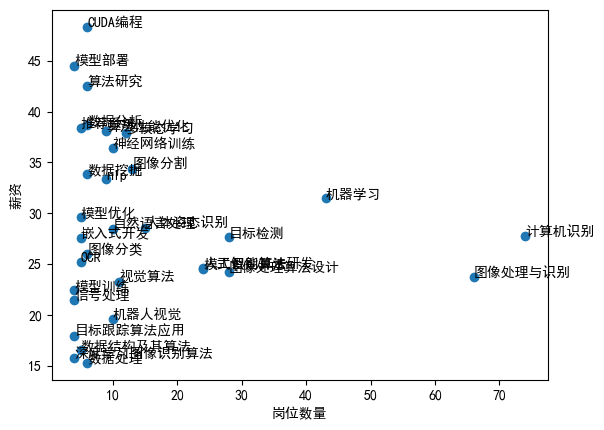

,领域,企业规模,企业规模_mean,岗位数量,薪资,薪资_mean,学历,学历_mean,工作年限,工作年限_mean,得分
6,计算机识别,"[6, 6, 9, 9, 3, 3, 5, 5, 5, 7, 3, 9, 8, 7, 8, ...",6.770270,74,"[70, 0, 45, 18, 60, 12, 18, 30, 30, 25, 35, 35...",27.770270,"[2, 4, 2, 3, 2, 2, 2, 3, 3, 4, 3, 2, 3, 3, 3, ...",2.635135,"[0, 0, 0, 0, 4, 3, 3, 4, 5, 0, 3, 4, 4, 4, 3, ...",2.229730,40.385075
13,机器学习,"[9, 13, 9, 9, 5, 3, 7, 3, 8, 5, 5, 3, 8, 7, 5,...",7.000000,43,"[30, 80, 45, 18, 26, 12, 25, 35, 20, 19, 20, 1...",31.511628,"[2, 2, 2, 3, 3, 2, 4, 3, 3, 3, 2, 3, 3, 3, 3, ...",2.651163,"[3, 0, 0, 0, 4, 3, 0, 3, 4, 0, 3, 3, 4, 3, 0, ...",2.627907,36.370162
3,图像处理与识别,"[6, 6, 5, 8, 3, 5, 7, 5, 7, 8, 7, 3, 8, 5, 3, ...",5.848485,66,"[70, 0, 26, 25, 12, 10, 20, 30, 30, 20, 25, 12...",23.727273,"[2, 4, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 2, 2, 3, ...",2.590909,"[0, 0, 4, 4, 3, 3, 4, 5, 4, 4, 4, 3, 3, 3, 3, ...",2.500000,34.905775
5,目标检测,"[6, 9, 3, 5, 7, 3, 9, 9, 3, 3, 5, 9, 6, 6, 2, ...",6.035714,28,"[70, 45, 11, 23, 30, 15, 0, 24, 20, 18, 21, 12...",27.642857,"[2, 2, 1, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, ...",2.428571,"[0, 0, 3, 0, 4, 3, 4, 3, 3, 0, 3, 0, 4, 4, 0, ...",2.071429,27.820282
27,图像处理算法设计,"[13, 3, 3, 9, 7, 3, 7, 5, 8, 7, 3, 3, 9, 8, 3,...",5.321429,28,"[50, 60, 11, 14, 20, 18, 25, 19, 18, 30, 20, 2...",24.285714,"[3, 2, 1, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, ...",2.535714,"[5, 4, 3, 0, 4, 4, 4, 0, 3, 4, 4, 3, 4, 4, 3, ...",2.892857,26.010929
29,人工智能算法研发,"[13, 5, 5, 5, 7, 3, 9, 3, 5, 3, 8, 9, 11, 13, ...",6.833333,24,"[50, 26, 30, 30, 25, 35, 35, 12, 20, 15, 25, 2...",24.666667,"[3, 3, 3, 3, 4, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, ...",2.708333,"[5, 4, 4, 5, 0, 3, 4, 3, 3, 3, 4, 3, 6, 0, 0, ...",2.958333,24.328767
40,模式识别算法,"[13, 3, 8, 3, 3, 8, 5, 9, 8, 3, 9, 5, 5, 5, 3,...",5.541667,24,"[80, 12, 20, 12, 15, 25, 27, 25, 25, 20, 24, 2...",24.500000,"[2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, ...",2.666667,"[0, 3, 4, 3, 3, 4, 3, 4, 4, 4, 3, 0, 0, 4, 3, ...",2.875000,24.247423
7,人体姿态识别,"[6, 3, 3, 3, 9, 5, 5, 6, 6, 13, 13, 4, 3, 0, 3]",5.466667,15,"[70, 11, 12, 20, 0, 20, 20, 25, 60, 40, 50, 16...",28.600000,"[2, 1, 2, 2, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2]",2.133333,"[0, 3, 3, 3, 4, 5, 4, 3, 5, 0, 0, 3, 0, 0, 3]",2.400000,19.678899
53,图像分割,"[9, 3, 3, 9, 6, 6, 2, 13, 13, 3, 3, 13, 9]",7.076923,13,"[18, 60, 15, 24, 20, 20, 25, 60, 40, 70, 40, 2...",34.384615,"[3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 2, 3]",2.615385,"[0, 4, 3, 3, 4, 4, 0, 0, 3, 0, 0, 0, 3]",1.846154,18.866883
10,多模态学习,"[9, 9, 9, 3, 2, 13, 13, 6, 13, 13, 13, 9]",9.333333,12,"[30, 40, 45, 35, 25, 60, 40, 30, 50, 30, 40, 30]",37.916667,"[2, 2, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3]",2.583333,"[3, 0, 0, 3, 0, 5, 0, 4, 0, 4, 3, 3]",2.083333,18.230384


In [16]:
# 为dfl增加一列计算得分，根据岗位数量和薪资_mean计算得分，两者在分数中的权重相同，得分满分为1
# 引入scipy库的harmonic mean函数
from scipy.stats import hmean
# 去除岗位数量小于5且大于50的数据
dfl = dfl[(dfl["岗位数量"] > 3) & (dfl["岗位数量"] < 80)]
# 计算得分
dfl['得分'] = hmean(dfl[['岗位数量', '薪资_mean']], axis=1)
# 按得分降序排列
dfl = dfl.sort_values(by="得分", ascending=False)

# 绘制薪资与岗位数量的平面图
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.scatter(dfl["岗位数量"], dfl["薪资_mean"])
# 遍历DataFrame的每一行，添加文本
for i in range(dfl.shape[0]):
    plt.text(dfl["岗位数量"].iloc[i], dfl["薪资_mean"].iloc[i], dfl["领域"].iloc[i], fontsize=10)

plt.xlabel("岗位数量")
plt.ylabel("薪资")
plt.show()
dfl[:20]

In [17]:
d2s["机器学习"]

['机器学习原理', '机器学习优化算法', '自动化机器学习']

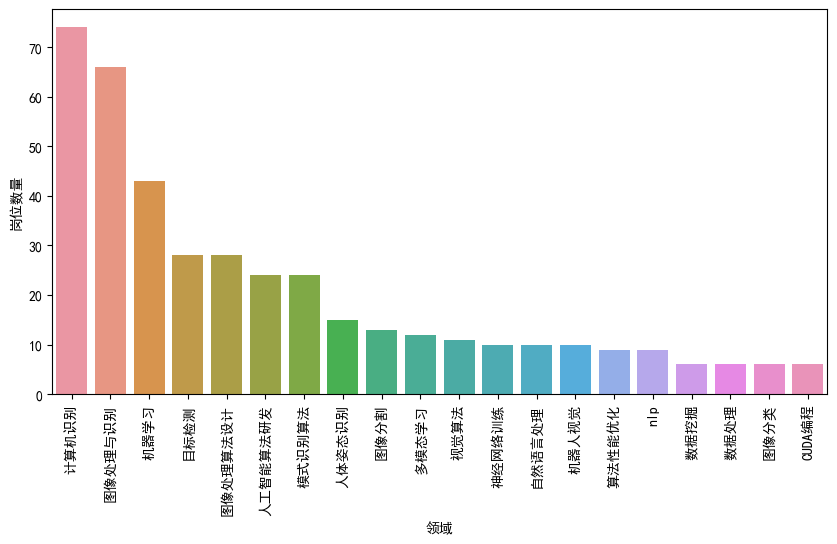

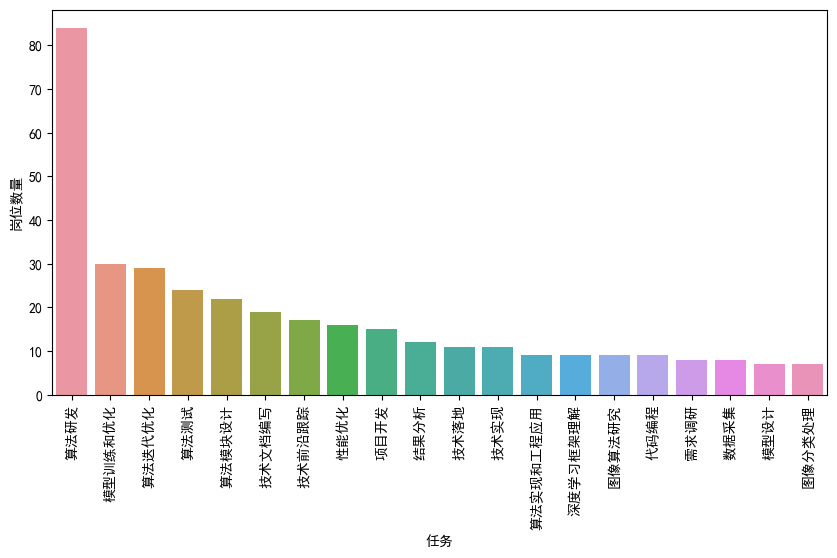

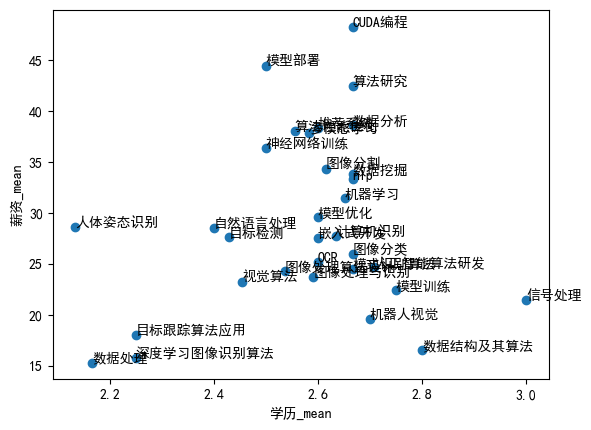

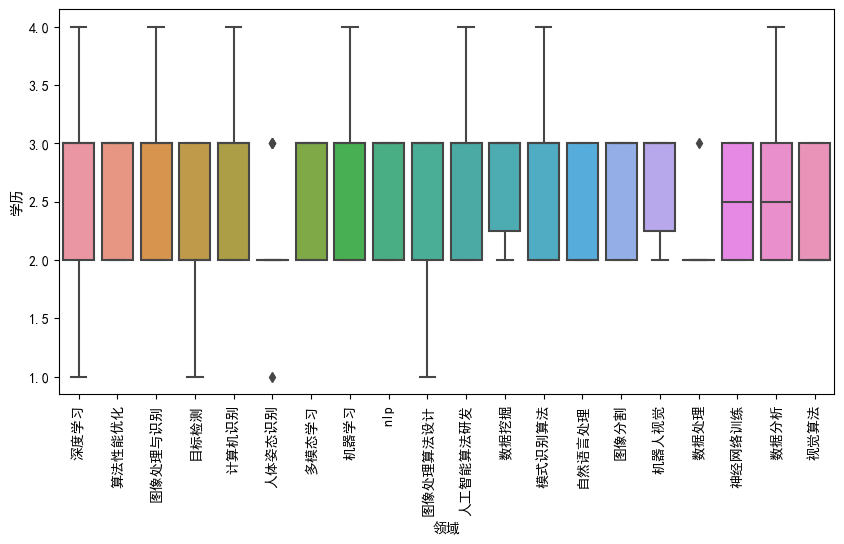

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
# 绘制岗位数量前10的领域的柱状图
def plot_bar(df, x, y, num=10):
    plt.figure(figsize=(10, 5))
    sns.barplot(x=x, y=y, data=df.sort_values(by=y, ascending=False)[:num])
    plt.xticks(rotation=90)
    plt.show()
# 绘制岗位数量前10的领域的企业规模箱线图
def plot_box(df_flat, df, x, y, num=10):
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=x, y=y, data=df_flat[df_flat[x].isin(df.sort_values(by=["岗位数量"], ascending=False)[:num][x])])
    plt.xticks(rotation=90)
    plt.show()

def plot_scatter(df, x, y):
    plt.scatter(df[x], df[y])
    # 遍历DataFrame的每一行，添加文本
    for i in range(df.shape[0]):
        plt.text(df[x].iloc[i], df[y].iloc[i], df["领域"].iloc[i], fontsize=10)

    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()
# 绘制岗位数量前10的学历和薪资的热力图
def plot_heatmap(df, x, y):
    # 根据岗位数量给df排序
    df = df.sort_values(by=["岗位数量"], ascending=False)
    plt.figure(figsize=(10, 5))
    sns.heatmap(df[:20].pivot_table(index=x, columns=y, values="岗位数量"), cmap="Blues")
    plt.show()



plot_bar(dfl, "领域", "岗位数量", 20)
plot_bar(df2, "任务", "岗位数量", 20)
plot_scatter(dfl, "学历_mean", "薪资_mean")
plot_box(df5_flat, df5, "领域", "学历", 20)

# plot_bar(dfl, "领域", "薪资_mean", 20)
# plot_box(df1_flat, df1, "领域", "企业规模", 20)
# plot_box(df2_flat, df2, "任务", "企业规模", 20)
# plot_box(df3_flat, df3, "领域", "薪资", 20)
# plot_box(df4_flat, df4, "任务", "薪资", 20)


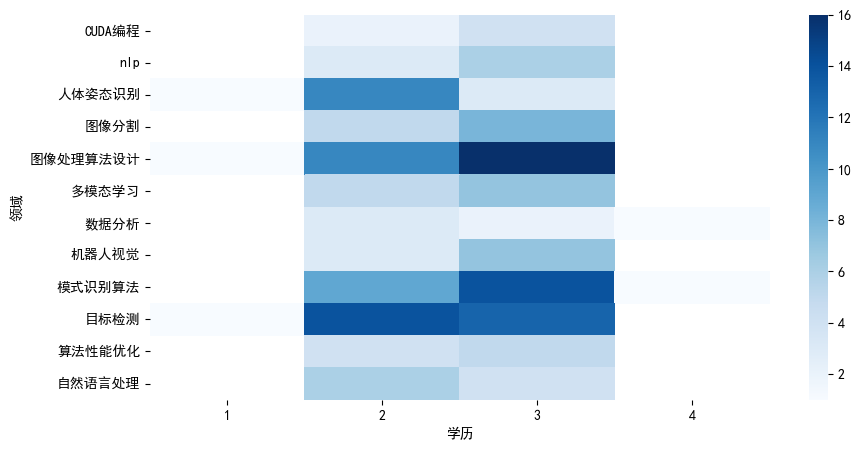

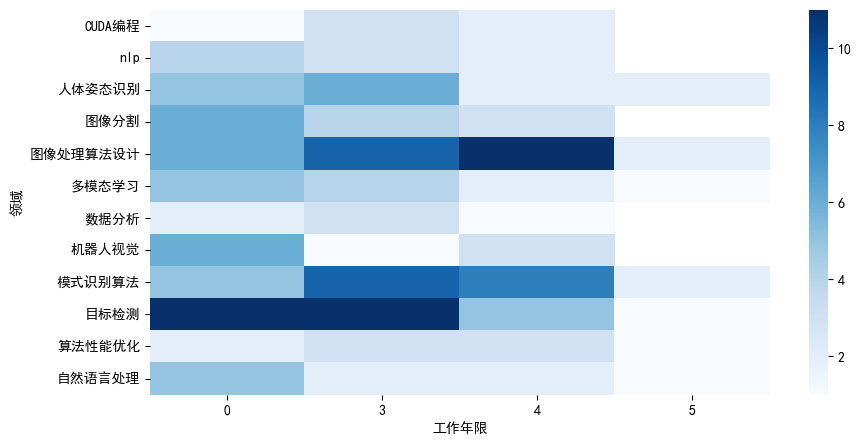

In [19]:
ai_list = ['图像处理算法设计','目标检测','模式识别算法','人体姿态识别','图像分割','多模态学习', '机器人视觉', '自然语言处理', 'nlp', '算法性能优化','CUDA编程','数据分析']
# 对"学历"和"关键词"进行分组，然后计算每个组的数量
df_grouped = bf1_flat.groupby(["学历", "领域"]).size().reset_index(name="数量")
df_grouped = df_grouped[df_grouped["领域"].isin(ai_list)]
# 创建热力图
plt.figure(figsize=(10, 5))
sns.heatmap(df_grouped.pivot_table(index="领域", columns="学历", values="数量"), cmap="Blues")
plt.show()
df2_grouped = bf2_flat.groupby(["工作年限", "领域"]).size().reset_index(name="数量")
df2_grouped = df2_grouped[df2_grouped["领域"].isin(ai_list)]
# 创建热力图
plt.figure(figsize=(10, 5))
sns.heatmap(df2_grouped.pivot_table(index="领域", columns="工作年限", values="数量"), cmap="Blues")
plt.show()

In [20]:
t2s["目标检测算法开发"]

['非标算法开发',
 '图像识别算法开发',
 '手势识别算法开发',
 '图像识别类算法研究开发',
 '对目标检测类算法有一定程度的理解',
 '缺陷检测算法开发']

In [21]:
d2s["CUDA编程"]

['CUDA 编程', 'GPU编程']

In [22]:
scale2l = defaultdict(list)
for i, ll in cv_data.iterrows():
    scale2l[ll["企业规模"]].extend(ll["领域"])

In [23]:
for i in scale2l:
    scale2l[i] = list(set(scale2l[i]))

In [24]:
scale2s = {}
for i in scale2l:
    scale2s[i] = ",".join(scale2l[i])

In [25]:
scale2s.keys()

dict_keys([6, 9, 13, 5, 8, 3, 7, 1, 11, 2, 4, 10, 12, 0])

In [26]:
from test import *
prompt = f"""提供给你的不同人数的企业规模所对应的领域关键词：
100-499人:{scale2s[100]}{scale2s[300]}
-----
0-100人:{scale2s[20]}{scale2s[0]}{scale2s[1]}
-----
500-999人:{scale2s[500]}
-----
1000-9999人:{scale2s[1000]}{scale2s[5000]}
-----
10000人以上:{scale2s[10000]}
-----
请根据关键词，总结五个档位的企业所对应的领域特点，返回为json格式，key为企业规模，value为领域特点。
除此之外，增加一个名为“总结”的key，返回不同规模的企业所对应的领域的差异性。
"""
# bg = ChatGPT_request(prompt)
print(prompt)
print(len(prompt))

KeyError: 100

In [ ]:
# domain_list = []
# for key in new_cache:
#     domain_list.extend(new_cache[key]['任务'])
# # task_list = list(set([new_cache[key]['任务'] for key in new_cache if '任务' in new_cache[key]]))
# domain_list = list(set(domain_list))
# len(domain_list)

In [ ]:
# try:
#     with open("k2e.cache", "rb") as f:
#         k2e = pickle.load(f)
# except:
#     print("Empty cache file")
#     k2e = {}

# # with open("similar.cache", "rb") as f:
# #     similar = pickle.load(f)
# # with open("finally_k.cache", "rb") as f:
# #     finally_k = pickle.load(f)
# similar = {}
# finally_k = []

In [ ]:
# from sklearn.metrics.pairwise import cosine_similarity
# import numpy as np

# # 将domain_list转换为一个2D数组
# embeddings = np.array([k2e[i] for i in domain_list])

# # 计算所有嵌入向量之间的余弦相似度
# similarity_matrix = cosine_similarity(embeddings)

# print(similarity_matrix)

In [ ]:
# # Find the column indices
# column_indices = np.where((similarity_matrix > 0.93) & (similarity_matrix < 0.99999))[1]

# print(column_indices)

In [ ]:
# # 统计column_indices中每个元素出现的次数
# from collections import Counter
# c = Counter(column_indices)
# # 取出出现次数大于5的元素
# finally_k = [i for i in c if c[i] > 1]
# # 遍历finally_k，如果similarity_matrix[i]
# best_k = []
# for i in finally_k:
#     t = False
#     yz = np.where(similarity_matrix[i] > 0.9)[0]
#     for j in best_k:
#         if j in yz:
#             t = True
#             print("remove", domain_list[i])
#             break
#     if not t:
#         best_k.append(i)
#         print("add", domain_list[i])   
# print(best_k)

In [ ]:
# # 元素转换为对应的domain
# best_domain = [domain_list[i] for i in best_k]
# print(best_domain)

In [ ]:
# similar = {}

# for i in range(len(similarity_matrix)):
#     a = 0
#     for j in best_k:
#         if i != j and similarity_matrix[i][j] > 0.9:
#             if similarity_matrix[i][j] > a:
#                 similar[domain_list[i]] = domain_list[j]
#                 print(domain_list[i], domain_list[j])
#                 a = similarity_matrix[i][j]


In [ ]:
# _similar = []
# # 查看不在similar中的domain
# for i in domain_list:
#     if i not in similar and i not in best_domain:
#         _similar.append(i)
# len(_similar)

In [ ]:
# # 将domain_list转换为一个2D数组
# embeddings = np.array([k2e[i] for i in _similar])

# # 计算所有嵌入向量之间的余弦相似度
# similarity_matrix = cosine_similarity(embeddings)

# print(similarity_matrix)

In [ ]:
# for i in range(len(similarity_matrix)):
#     index = np.argsort(similarity_matrix[i])[-2]
#     if similarity_matrix[i][index] > 0.9 and _similar[i] not in similar and _similar[index] not in similar:
#         similar[_similar[i]] = _similar[index]
#         print(_similar[i], _similar[index])

In [ ]:
# finally_k = []
# for i in similar.values():
#     if i not in finally_k:
#         finally_k.append(i)
# len(finally_k)

In [ ]:
# with open("k2e.cache", "wb") as f:
#     pickle.dump(k2e, f)

In [ ]:
# with open("similar_task.cache", "wb") as f:
#     pickle.dump(similar, f)

# with open("finally_task.cache", "wb") as f:    # 保存
#     pickle.dump(finally_k, f)

In [ ]:
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# # 假设X是你的嵌入向量
# X = np.array([k2e[i] for i in domain_list])

# # 执行聚类
# kmeans = KMeans(n_clusters=200, random_state=0).fit(X)

# # 打印聚类结果
# print(kmeans.labels_)

In [ ]:
# 打印聚类中心并转换为domain

